<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-NEB-end-structures" data-toc-modified-id="Prepare-NEB-end-structures-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare NEB end structures</a></span><ul class="toc-item"><li><span><a href="#Download-from-Materials-Project-and-create-supercell" data-toc-modified-id="Download-from-Materials-Project-and-create-supercell-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download from Materials Project and create supercell</a></span></li><li><span><a href="#Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span></li><li><span><a href="#Create-and-relax-NEB-end-structures----b-and-c-directions" data-toc-modified-id="Create-and-relax-NEB-end-structures----b-and-c-directions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create and relax NEB end structures -- b and c directions</a></span></li></ul></li><li><span><a href="#NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span><ul class="toc-item"><li><span><a href="#generate-NEB-images-from-end-structures-and-conduct-NEB" data-toc-modified-id="generate-NEB-images-from-end-structures-and-conduct-NEB-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>generate NEB images from end structures and conduct NEB</a></span></li><li><span><a href="#analyze-and-plot-NEB-results" data-toc-modified-id="analyze-and-plot-NEB-results-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>analyze and plot NEB results</a></span></li><li><span><a href="#Store-NEB-images-in-one-cif-file-for-visualization" data-toc-modified-id="Store-NEB-images-in-one-cif-file-for-visualization-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Store NEB images in one cif file for visualization</a></span></li><li><span><a href="#Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)" data-toc-modified-id="Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Visualize NEB path (snapshots of VESTA visualization of path_final.cif)</a></span></li></ul></li></ul></div>


DFT barrier heights: path b = 0.27 eV and path c = 2.5 eV. (see table 1 in https://doi.org/10.1039/C5TA05062F)


In [ ]:
from __future__ import annotations

from pymatgen.ext.matproj import MPRester
from ase.neb import NEB, NEBTools

from matcalc.util import get_universal_calculator

mpr = MPRester("mp-api-key")

# Prepare NEB end structures


## Download from Materials Project and create supercell


In [ ]:
s_LFPO = mpr.get_structure_by_material_id("mp-19017")
s_LFPO.make_supercell([1, 2, 2], in_place=True)
s_LFPO.to("NEB_data/LiFePO4_supercell.cif", "cif")
s_LFPO.lattice.abc, s_LFPO.formula

((10.23619605, 11.941510200000154, 9.309834380000202), 'Li16 Fe16 P16 O64')

## Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet


In [ ]:
models = {
    "M3GNet-DIRECT": get_universal_calculator("M3GNet-MP-2021.2.8-DIRECT-PES"),
    "M3GNet-MS": get_universal_calculator("M3GNet-MP-2021.2.8-PES"),
    "CHGNet": get_universal_calculator("CHGNet"),
}

In [ ]:
%%time
results = {}
for model_name, model in models.items():
    relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=True, fmax=0.02)
    supercell_LFPO_relaxed = relaxer.calc(s_LFPO)["final_structure"]
    results[model_name] = {"supercell_LFPO": supercell_LFPO_relaxed}

/Users/qiji/repos/matgl/src/matgl/layers/_basis.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  root = torch.tensor(roots[i])
/Users/qiji/miniconda3/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


CPU times: user 6min 26s, sys: 4min 10s, total: 10min 36s
Wall time: 1min 35s


## Create and relax NEB end structures -- b and c directions


In [ ]:
%%time
for model_name, model in models.items():
    relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=False, fmax=0.02)
    supercell_LFPO_relaxed = results[model_name]["supercell_LFPO"]

    # NEB path along b and c directions have the same starting image.
    s_LFPO_end_b = supercell_LFPO_relaxed.copy()
    s_LFPO_end_b.remove_sites([11])
    s_LFPO_end_b_relaxed = relaxer.calc(s_LFPO_end_b)["final_structure"]
    s_LFPO_end_c = supercell_LFPO_relaxed.copy()
    s_LFPO_end_c.remove_sites([4])
    s_LFPO_end_c_relaxed = relaxer.calc(s_LFPO_end_c)["final_structure"]
    s_LFPO_start_bc = supercell_LFPO_relaxed.copy()
    s_LFPO_start_bc.remove_sites([5])
    s_LFPO_start_bc_relaxed = relaxer.calc(s_LFPO_start_bc)["final_structure"]
    results[model_name].update(
        {
            "supercell_LFPO_end_b": s_LFPO_end_b_relaxed,
            "supercell_LFPO_end_c": s_LFPO_end_c_relaxed,
            "supercell_LFPO_start_bc": s_LFPO_start_bc_relaxed,
        }
    )

CPU times: user 6min 5s, sys: 4min 2s, total: 10min 7s
Wall time: 1min 47s


# NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet

The universal potentials provide reasonable agreement with each other and with literature.

References:

1. https://pubs.rsc.org/en/content/articlelanding/2011/ee/c1ee01782a
2. https://doi.org/10.1103/PhysRevApplied.7.034007


## generate NEB images from end structures and conduct NEB


In [ ]:
%%time
for neb_path in "bc":
    for model_name, model in models.items():
        NEBcalc = NEBCalc.from_end_images(
            start_struct=results[model_name]["supercell_LFPO_start_bc"],
            end_struct=results[model_name][f"supercell_LFPO_end_{neb_path}"],
            calculator=model,
            n_images=7,
            climb=True,
            traj_folder=f"NEB_data/traj_{neb_path}_{model_name}/"
        )
        barrier = NEBcalc.calc(fmax=0.05)[0]
        results[model_name][f"NEB_{neb_path}"] = NEBcalc.neb
        print(f"Barrier along {neb_path} by {model_name}: {barrier} eV.")

      Step     Time          Energy         fmax
BFGS:    0 15:19:23     -756.289551        1.7385
BFGS:    1 15:19:33     -756.400269        1.1797
BFGS:    2 15:19:44     -756.557556        0.7485
BFGS:    3 15:19:55     -756.633423        0.5410
BFGS:    4 15:20:05     -756.664551        0.4628
BFGS:    5 15:20:16     -756.674255        0.4553
BFGS:    6 15:20:27     -756.685913        0.4410
BFGS:    7 15:20:37     -756.703186        0.4304
BFGS:    8 15:20:47     -756.723999        0.3180
BFGS:    9 15:20:58     -756.737427        0.3052
BFGS:   10 15:21:09     -756.743713        0.3104
BFGS:   11 15:21:19     -756.752258        0.3113
BFGS:   12 15:21:30     -756.762878        0.2574
BFGS:   13 15:21:40     -756.776611        0.2825
BFGS:   14 15:21:51     -756.789490        0.2677
BFGS:   15 15:22:01     -756.797546        0.2350
BFGS:   16 15:22:12     -756.802307        0.2246
BFGS:   17 15:22:22     -756.807617        0.1795
BFGS:   18 15:22:33     -756.815979        0.1706
B

Barrier along c by M3GNet-MS: 0.8385009765624982 eV.
      Step     Time          Energy         fmax
BFGS:    0 15:53:34     -835.787680        6.1364
BFGS:    1 15:53:44     -836.417958        2.7437
BFGS:    2 15:53:55     -836.680432        1.4703
BFGS:    3 15:54:10     -836.901305        0.8638
BFGS:    4 15:54:22     -836.977469        0.8676
BFGS:    5 15:54:32     -837.087403        0.7341
BFGS:    6 15:54:42     -837.182093        0.7841
BFGS:    7 15:54:53     -837.234545        0.4048
BFGS:    8 15:55:02     -837.248836        0.3205
BFGS:    9 15:55:13     -837.258204        0.4190
BFGS:   10 15:55:26     -837.276835        0.4181
BFGS:   11 15:55:39     -837.293561        0.2552
BFGS:   12 15:55:54     -837.299595        0.2638
BFGS:   13 15:56:05     -837.302771        0.2829
BFGS:   14 15:56:18     -837.309704        0.3134
BFGS:   15 15:56:30     -837.317697        0.2168
BFGS:   16 15:56:44     -837.320978        0.1450
BFGS:   17 15:56:56     -837.321507        0.171

## analyze and plot NEB results


Path along b, M3GNet-DIRECT: 


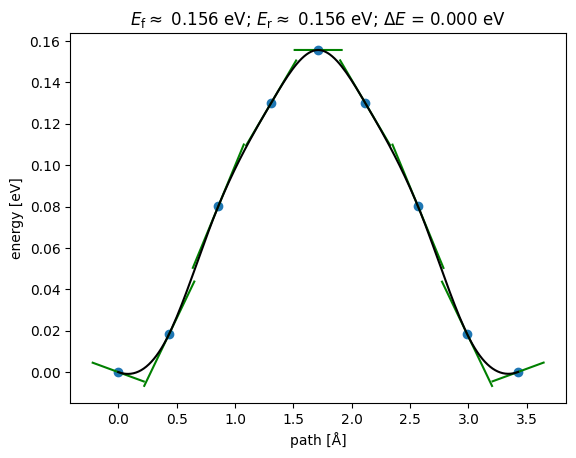

Path along b, M3GNet-MS: 


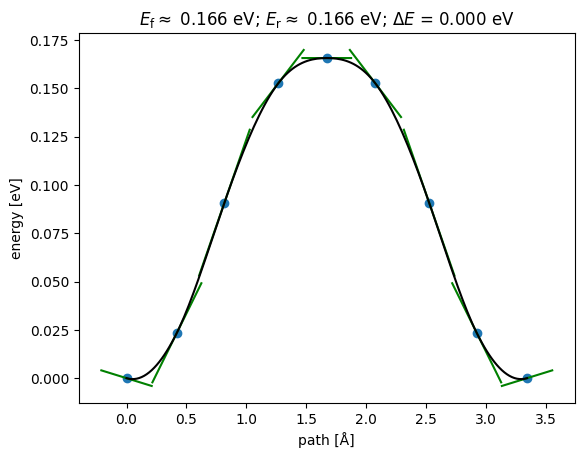

Path along b, CHGNet: 


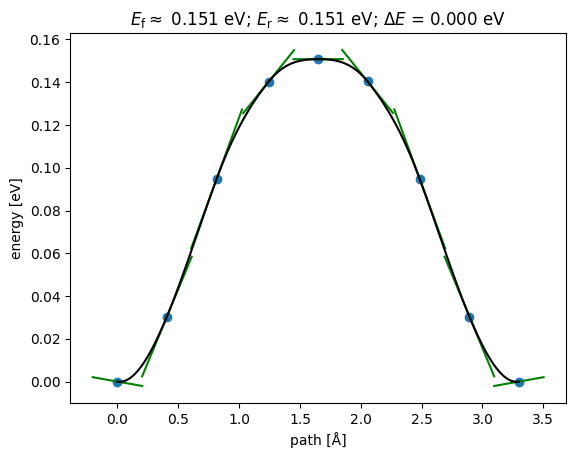

Path along c, M3GNet-DIRECT: 


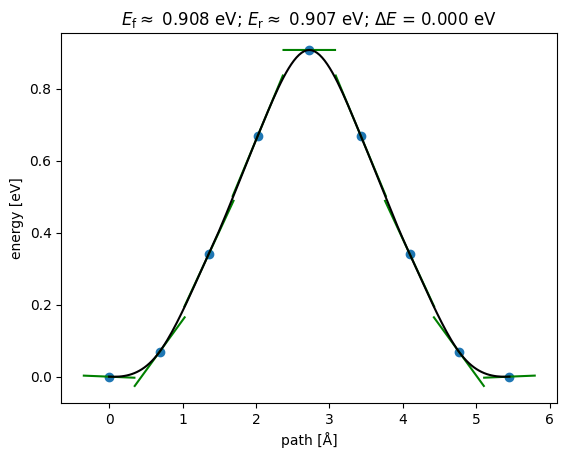

Path along c, M3GNet-MS: 


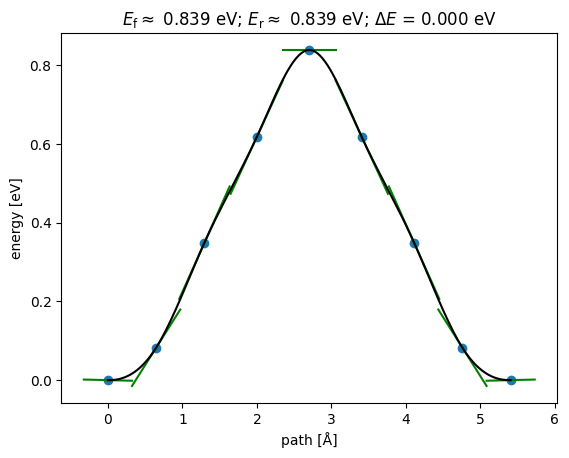

Path along c, CHGNet: 


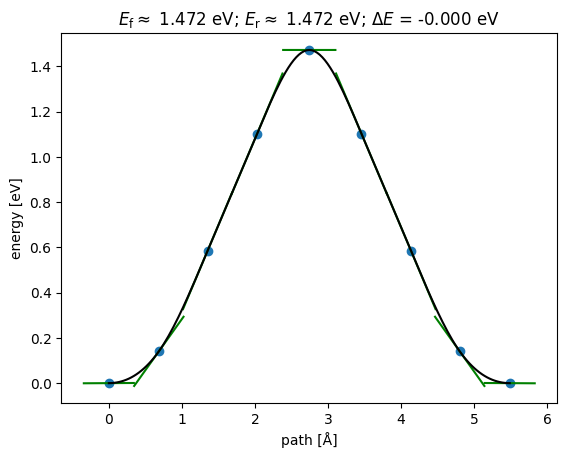

CPU times: user 2min 33s, sys: 1min 7s, total: 3min 41s
Wall time: 50 s


In [ ]:
%%time
import matplotlib.pyplot as plt

for neb_path in "bc":
    for model_name, model in models.items():
        NEB_tool = NEBTools(results[model_name][f"NEB_{neb_path}"].images)
        print(f"Path along {neb_path}, {model_name}: ")
        fig = NEB_tool.plot_band()
        plt.show()

## Store NEB images in one cif file for visualization


In [ ]:
from itertools import chain

from pymatgen.core import PeriodicSite, Structure
from pymatgen.io.ase import AseAtomsAdaptor


def generate_path_cif_from_images(images: list, filename: str) -> None:
    """Generate a cif file from a list of image atoms."""
    image_structs = list(map(AseAtomsAdaptor().get_structure, images))
    sites = set()
    lattice = image_structs[0].lattice
    sites.update(PeriodicSite(site.species, site.frac_coords, lattice) for site in chain(*(struct for struct in image_structs)))
    neb_path = Structure.from_sites(sorted(sites))
    neb_path.to(filename, "cif")

In [ ]:
%%time
for neb_path in "bc":
    for model_name, model in models.items():
        NEB_tool = NEBTools(results[model_name][f"NEB_{neb_path}"].images)
        generate_path_cif_from_images(NEB_tool.images, f"NEB_data/traj_{neb_path}_{model_name}/path_final.cif")

CPU times: user 23.7 s, sys: 193 ms, total: 23.9 s
Wall time: 20.6 s


## Visualize NEB path (snapshots of VESTA visualization of path_final.cif)


In [ ]:
from IPython.display import Image

Final path b by M3GNet-DIRECT:


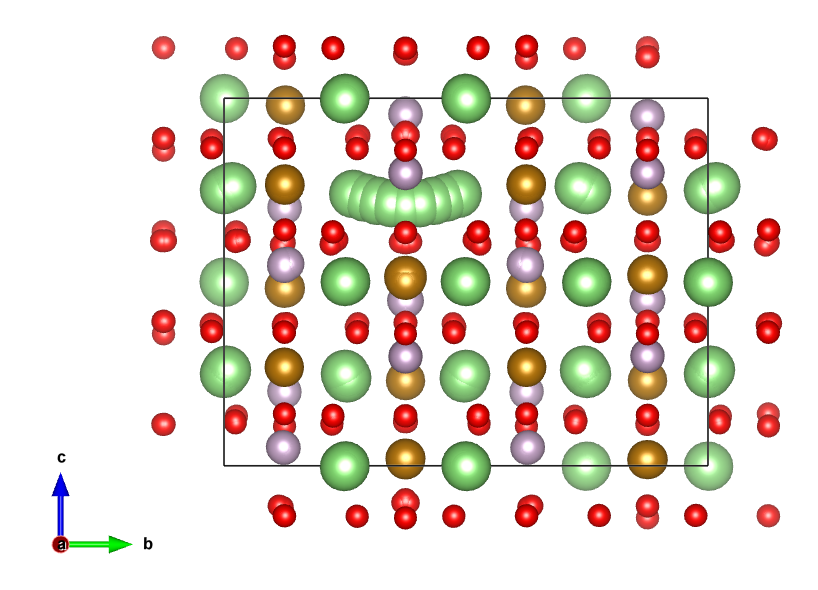

In [ ]:
print("Final path b by M3GNet-DIRECT:")
Image("NEB_data/M3GNet-DIRECT-path-b.png")

Final path c by M3GNet-DIRECT:


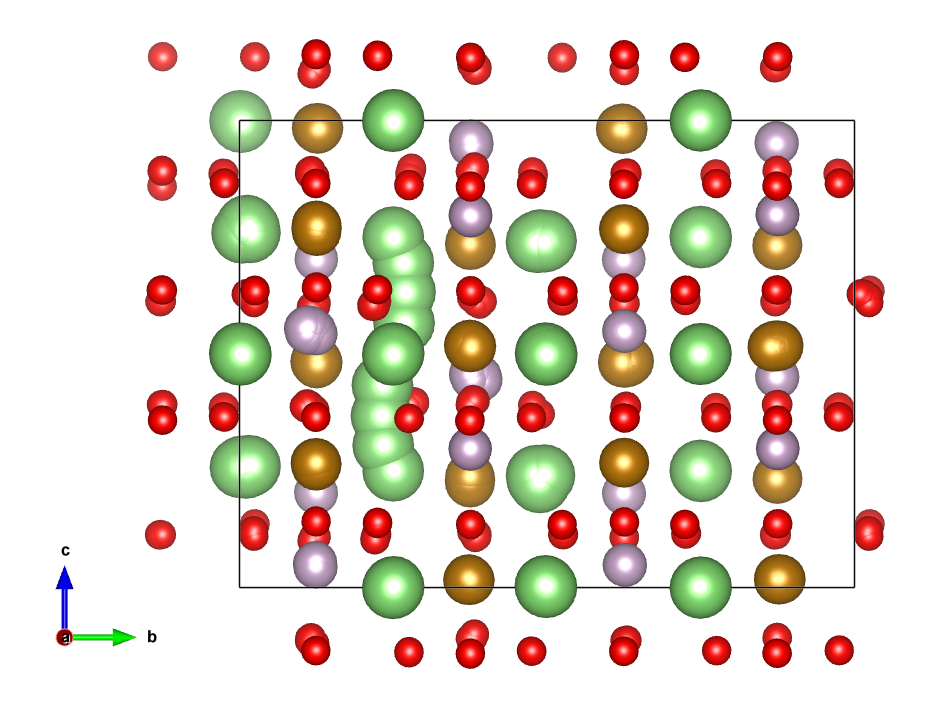

In [ ]:
print("Final path c by M3GNet-DIRECT:")
Image("NEB_data/M3GNet-DIRECT-path-c.png")